In [44]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pybaseball import batting_stats, pitching_stats

# -------------------------------
# Step 1: Data Acquisition
# -------------------------------
print("Fetching player statistics...")
batters_2023 = batting_stats(2023)
pitchers_2023 = pitching_stats(2023)

# Filter players from White Sox and Cubs
white_sox_batters = batters_2023[batters_2023['Team'] == 'CHW']
cubs_batters = batters_2023[batters_2023['Team'] == 'CHC']
white_sox_pitchers = pitchers_2023[pitchers_2023['Team'] == 'CHW']
cubs_pitchers = pitchers_2023[pitchers_2023['Team'] == 'CHC']



Fetching player statistics...


In [46]:
# -------------------------------
# Step 2: Data Preparation & Cleaning
# -------------------------------
def clean_batter_data(df):
    # Remove players with missing essential stats and low plate appearances (PA)
    df = df.dropna(subset=['AVG', 'AB', 'PA', 'HR', 'BB', 'SO'])
    df = df[df['PA'] >= 50]
    return df

def clean_pitcher_data(df):
    # Remove pitchers with missing essential stats and low innings pitched (IP)
    df = df.dropna(subset=['AVG', 'IP', 'H', 'BB', 'SO'])
    df['IP'] = pd.to_numeric(df['IP'], errors='coerce')
    df = df.dropna(subset=['IP'])
    df = df[df['IP'] >= 10]
    return df

white_sox_batters = clean_batter_data(white_sox_batters)
cubs_batters = clean_batter_data(cubs_batters)
white_sox_pitchers = clean_pitcher_data(white_sox_pitchers)
cubs_pitchers = clean_pitcher_data(cubs_pitchers)

print(f"White Sox Batters: {len(white_sox_batters)}, Cubs Batters: {len(cubs_batters)}")
print(f"White Sox Pitchers: {len(white_sox_pitchers)}, Cubs Pitchers: {len(cubs_pitchers)}")


White Sox Batters: 4, Cubs Batters: 5
White Sox Pitchers: 1, Cubs Pitchers: 1


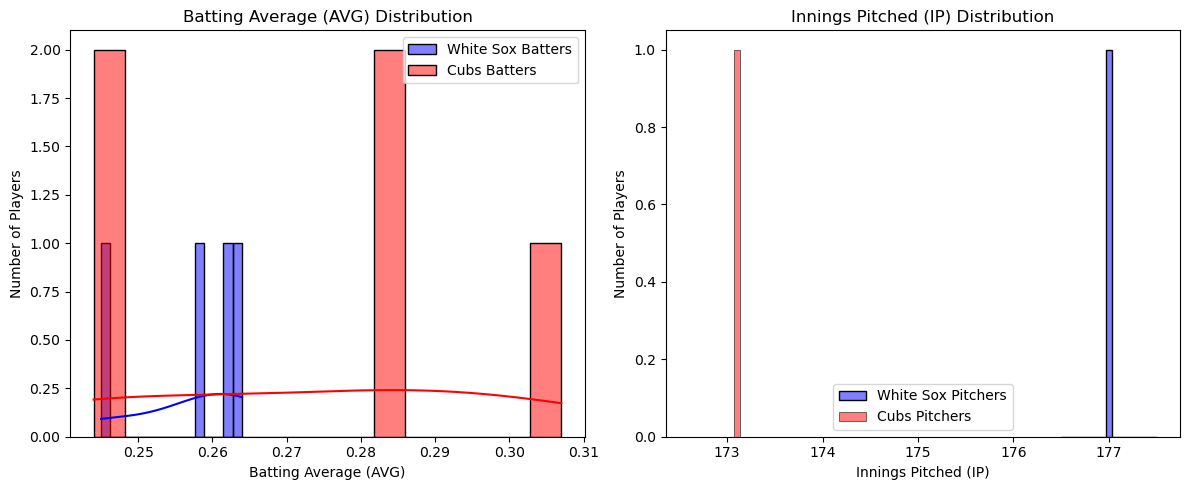

In [48]:
# -------------------------------
# Step 2.5: Data Distribution Visualization
# -------------------------------

plt.figure(figsize=(12, 5))

# Left: Batter AVG Distribution
plt.subplot(1, 2, 1)
sns.histplot(white_sox_batters['AVG'], kde=True, color='blue', label='White Sox Batters', bins=15)
sns.histplot(cubs_batters['AVG'], kde=True, color='red', label='Cubs Batters', bins=15)
plt.title('Batting Average (AVG) Distribution')
plt.xlabel('Batting Average (AVG)')
plt.ylabel('Number of Players')
plt.legend()

# Right: Pitcher IP Distribution
plt.subplot(1, 2, 2)
sns.histplot(white_sox_pitchers['IP'], kde=True, color='blue', label='White Sox Pitchers', bins=15)
sns.histplot(cubs_pitchers['IP'], kde=True, color='red', label='Cubs Pitchers', bins=15)
plt.title('Innings Pitched (IP) Distribution')
plt.xlabel('Innings Pitched (IP)')
plt.ylabel('Number of Players')
plt.legend()

plt.tight_layout()
plt.show()

In [50]:
# -------------------------------
# Step 3: Simulation Functions
# -------------------------------

# Calculate matchup probability between a batter and a pitcher
def matchup_probability(batter_avg, pitcher_avg):
    return (batter_avg * pitcher_avg) / (batter_avg * pitcher_avg + (1 - batter_avg) * (1 - pitcher_avg) + 1e-6)

# Estimate Batters Faced (BF) for a pitcher
def estimate_bf(pitcher):
    ip = pitcher.get('IP', 0)
    h = pitcher.get('H', 0)
    bb = pitcher.get('BB', 0)
    try:
        ip = float(ip)
    except:
        ip = 0
    innings_whole = int(ip)
    partial_outs = (ip - innings_whole) * 10
    outs = innings_whole * 3 + partial_outs
    bf = outs + h + bb
    return bf if bf > 0 else 1

# Simulate a single at-bat between a batter and a pitcher
def simulate_at_bat(batter, pitcher):
    batter_avg = batter['AVG']
    batter_hr_rate = batter['HR'] / batter['AB'] if batter['AB'] > 0 else 0
    batter_bb_rate = batter['BB'] / batter['PA'] if batter['PA'] > 0 else 0
    batter_so_rate = batter['SO'] / batter['PA'] if batter['PA'] > 0 else 0

    pitcher_avg = pitcher['AVG']
    bf = estimate_bf(pitcher)
    pitcher_bb_rate = pitcher['BB'] / bf
    pitcher_so_rate = pitcher['SO'] / bf

    # Calculate outcome probabilities
    hit_prob = matchup_probability(batter_avg, pitcher_avg)
    hr_prob = matchup_probability(batter_hr_rate, pitcher_avg)
    bb_prob = matchup_probability(batter_bb_rate, pitcher_bb_rate)
    so_prob = matchup_probability(batter_so_rate, pitcher_so_rate)
    remaining_prob = max(0, 1 - (hit_prob + hr_prob + bb_prob + so_prob))

    outcomes = ['Hit', 'HR', 'BB', 'SO', 'Out']
    probs = [hit_prob, hr_prob, bb_prob, so_prob, remaining_prob]

    return np.random.choice(outcomes, p=probs)

# Simulate a single game between two teams
def simulate_game(batters_team, pitchers_team, innings=9):
    score = 0
    batter_idx = 0
    for inning in range(innings):
        outs = 0
        while outs < 3:
            batter = batters_team.iloc[batter_idx % len(batters_team)]
            pitcher = pitchers_team.sample(1).iloc[0]
            result = simulate_at_bat(batter, pitcher)
            
            # Update score and outs based on outcome
            if result in ['HR', 'Hit']:
                score += 1
            elif result == 'BB':
                continue  # Walk, no out, simplified base running
            else:
                outs += 1
            batter_idx += 1
    return score



In [52]:
# -------------------------------
# Step 4: Monte Carlo Simulation
# -------------------------------
print("Running Monte Carlo simulations...")
simulations = 1000
white_sox_scores = [simulate_game(white_sox_batters, cubs_pitchers) for _ in range(simulations)]
cubs_scores = [simulate_game(cubs_batters, white_sox_pitchers) for _ in range(simulations)]

white_sox_wins = np.sum(np.array(white_sox_scores) > np.array(cubs_scores))
cubs_wins = np.sum(np.array(white_sox_scores) < np.array(cubs_scores))
ties = simulations - white_sox_wins - cubs_wins

print(f"\nSimulation Results (Total {simulations} Games):")
print(f"White Sox Win Rate: {white_sox_wins/simulations:.2%}")
print(f"Cubs Win Rate: {cubs_wins/simulations:.2%}")
print(f"Tie Rate: {ties/simulations:.2%}")

Running Monte Carlo simulations...

Simulation Results (Total 1000 Games):
White Sox Win Rate: 35.90%
Cubs Win Rate: 50.40%
Tie Rate: 13.70%


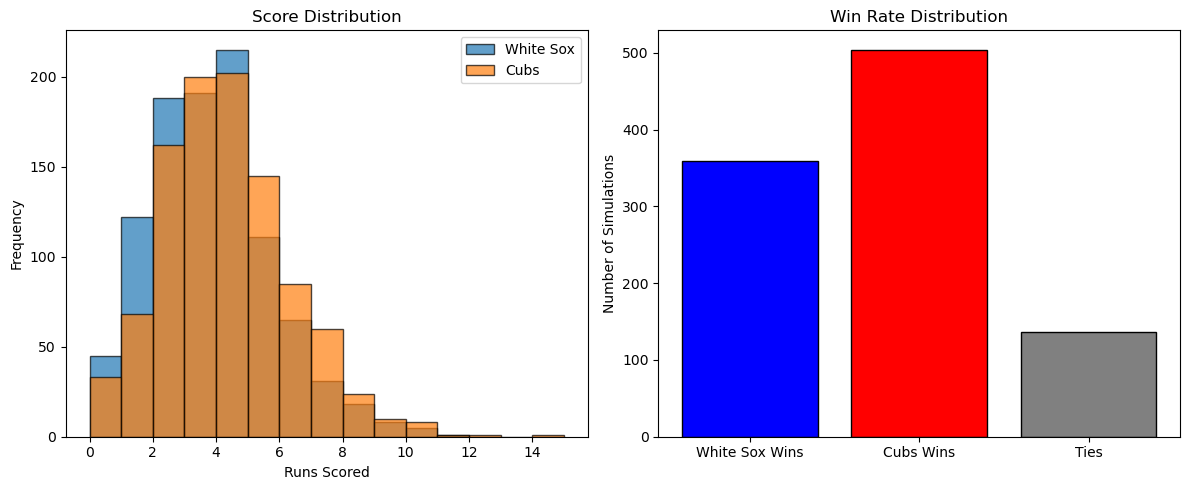

In [53]:
# -------------------------------
# Step 5: Visualization
# -------------------------------
plt.figure(figsize=(12, 5))

# Left plot: Score Distribution Histogram
plt.subplot(1, 2, 1)
plt.hist(white_sox_scores, bins=range(0, max(white_sox_scores)+2), alpha=0.7, label='White Sox', edgecolor='black')
plt.hist(cubs_scores, bins=range(0, max(cubs_scores)+2), alpha=0.7, label='Cubs', edgecolor='black')
plt.title('Score Distribution')
plt.xlabel('Runs Scored')
plt.ylabel('Frequency')
plt.legend()

# Right plot: Win Rate Distribution
plt.subplot(1, 2, 2)
results = ['White Sox Wins', 'Cubs Wins', 'Ties']
counts = [white_sox_wins, cubs_wins, ties]
plt.bar(results, counts, color=['blue', 'red', 'gray'], edgecolor='black')
plt.title('Win Rate Distribution')
plt.ylabel('Number of Simulations')

plt.tight_layout()
plt.show()